In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame as df
import xarray as xr
import netCDF4 as nc
import os
import requests
from datetime import timedelta
import tensorflow as tf
from datetime import datetime

In [ ]:
ds_SALT = xr.open_dataset("../SODA/salt_combined.nc" , decode_times=False)

In [70]:
#### 

In [71]:
df_VK08_TCCount = pd.read_table('../SODA/VK08_TCCounts_1878-2020.dat', sep="\s+", header=None)
df_VK08_TCCount = df_VK08_TCCount.rename(columns={0: "Year", 1:"VK08_TCCount"}).copy()
ds_SST = xr.open_dataset("../SODA/SST.nc" , decode_times=True)

ds_ssh = xr.open_dataset("../SODA/data.nc" , decode_times=False)
def fix_calendar(ds, timevar='time'):
    if ds[timevar].attrs['calendar'] == '360':
        ds[timevar].attrs['calendar'] = '360_day'
    return ds

ds_ssh = fix_calendar(ds_ssh)
ds_ssh = xr.decode_cf(ds_ssh)


In [73]:
ds_SST_sub = ds_SST.where(((ds_SST.lon>40 )&(ds_SST.lon<80) & (ds_SST.lat>10 )&(ds_SST.lat<20)  ), drop=True)
ds_ssh = ds_ssh.where(((ds_ssh.lon > 40 ) & (ds_ssh.lon < 80 ) & (ds_ssh.lat > 10) & (ds_ssh.lat <20)), drop=True)

df_sst = pd.DataFrame()
df_sst['time'] = np.array((ds_SST_sub['time']))
df_sst['sst'] = ''
for i in range(len(df_sst)):
  #df_sst['time'][i] = pd.Timestamp(1891, 1, 1) + timedelta(days= df_sst['time'][i])
  df_sst['sst'][i] = np.array((ds_SST_sub['sst'][i]))
    
df_ssh= pd.DataFrame()
np.array((ds_ssh['time'][0]))
df_ssh['time'] = np.array((ds_ssh['time']))
df_ssh['ssh'] = ''
for i in range(1656):
  df_ssh['ssh'][i] = np.array((ds_ssh['ssh'][i]))


<ipython-input-73-6c5a4bec6239>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sst['sst'][i] = np.array((ds_SST_sub['sst'][i]))


In [74]:
# Interpolation
from scipy.interpolate import NearestNDInterpolator
for i in range(len(df_sst)):
  data = df_sst['sst'][i] 
  mask = np.where(~np.isnan(data))
  interp = NearestNDInterpolator(np.transpose(mask), data[mask])
  filled_data = interp(*np.indices(data.shape))
  df_sst['sst'][i] = filled_data

for i in range(len(df_ssh)):
  data = df_ssh['ssh'][i] 
  mask = np.where(~np.isnan(data))
  interp = NearestNDInterpolator(np.transpose(mask), data[mask])
  filled_data = interp(*np.indices(data.shape))
  df_ssh['ssh'][i] = filled_data

<ipython-input-74-e89d98ca57db>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sst['sst'][i] = filled_data


In [75]:
def convert_to_dt(x):
    return datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')


df_sst["time"] = df_sst.time.apply(convert_to_dt)
df_sst['Month'] = 0
df_sst['Year'] = 0
for i in range(len(df_sst)):
    df_sst['Month'][i] =df_sst['time'][i].month
    df_sst['Year'][i] =df_sst['time'][i].year
    
df_ssh["time"] = df_ssh.time.apply(convert_to_dt)
df_ssh['Month'] = 0
df_ssh['Year'] = 0
for i in range(len(df_ssh)):
    df_ssh['Month'][i] =df_ssh['time'][i].month
    df_ssh['Year'][i] =df_ssh['time'][i].year

<ipython-input-75-883c216368cd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sst['Month'][i] =df_sst['time'][i].month
<ipython-input-75-883c216368cd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sst['Year'][i] =df_sst['time'][i].year
<ipython-input-75-883c216368cd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ssh['Month'][i] =df_ssh['time'][i].month
<ipython-input-75-883c216368cd>:17: SettingWithCopyWarning: 
A v

In [76]:
df_sst

,time,sst,Month,Year
0,1891-01-01,"[[27.16, 27.16, 26.785, 26.785, 26.785, 26.785...",1,1891
1,1891-02-01,"[[26.29, 26.29, 26.2525, 26.2525, 26.2525, 26....",2,1891
2,1891-03-01,"[[26.1775, 26.1775, 26.3875, 26.3875, 26.3875,...",3,1891
3,1891-04-01,"[[28.0025, 28.0025, 28.1575, 28.1575, 28.1575,...",4,1891
4,1891-05-01,"[[29.7825, 29.7825, 30.04, 30.04, 30.04, 30.04...",5,1891
...,...,...,...,...
1575,2022-04-01,"[[28.885, 28.885, 29.1475, 29.1475, 29.1475, 2...",4,2022
1576,2022-05-01,"[[29.85, 29.85, 30.42, 30.42, 30.42, 30.42, 30...",5,2022
1577,2022-06-01,"[[30.51, 30.51, 30.9775, 30.9775, 30.9775, 30....",6,2022
1578,2022-07-01,"[[30.97, 30.97, 31.07, 31.07, 31.07, 31.07, 31...",7,2022


In [77]:
df_ssh['ssh'][0].shape

(20, 80)

In [78]:
df_VK08_TCCount

,Year,VK08_TCCount,7year_rolling_avg
0,1878,15.370,NaN
1,1879,11.308,NaN
2,1880,14.084,NaN
3,1881,10.234,NaN
4,1882,9.183,12.0358
...,...,...,...
138,2016,15.000,13.4000
139,2017,17.000,13.0000
140,2018,15.000,13.2000
141,2019,18.000,15.2000


In [79]:
df_combined = pd.merge(df_sst,df_ssh[['ssh','Year','Month']],how = 'inner',on = ['Month','Year']).drop(axis = 1,labels = ['Month'])

In [80]:
df_combined

,time,sst,Year,ssh
0,1891-01-01,"[[27.16, 27.16, 26.785, 26.785, 26.785, 26.785...",1891,"[[0.2747103, 0.2747103, 0.2747103, 0.2747103, ..."
1,1891-02-01,"[[26.29, 26.29, 26.2525, 26.2525, 26.2525, 26....",1891,"[[0.26382777, 0.26382777, 0.26382777, 0.263827..."
2,1891-03-01,"[[26.1775, 26.1775, 26.3875, 26.3875, 26.3875,...",1891,"[[0.25022164, 0.25022164, 0.25022164, 0.250221..."
3,1891-04-01,"[[28.0025, 28.0025, 28.1575, 28.1575, 28.1575,...",1891,"[[0.23127134, 0.23127134, 0.23127134, 0.231271..."
4,1891-05-01,"[[29.7825, 29.7825, 30.04, 30.04, 30.04, 30.04...",1891,"[[0.14518131, 0.14518131, 0.14518131, 0.145181..."
...,...,...,...,...
1411,2008-08-01,"[[31.4075, 31.4075, 31.5275, 31.5275, 31.5275,...",2008,"[[-0.07573862, -0.07573862, -0.07573862, -0.07..."
1412,2008-09-01,"[[32.015, 32.015, 32.3425, 32.3425, 32.3425, 3...",2008,"[[0.016924672, 0.016924672, 0.016924672, 0.016..."
1413,2008-10-01,"[[31.465, 31.465, 31.82, 31.82, 31.82, 31.82, ...",2008,"[[0.084852025, 0.084852025, 0.084852025, 0.084..."
1414,2008-11-01,"[[29.7775, 29.7775, 29.9, 29.9, 29.9, 29.9, 29...",2008,"[[0.16070645, 0.16070645, 0.16070645, 0.160706..."


In [81]:
### DATA EXPLORATION ###

[Text(0.5, 1.0, 'TC Count Visulization Over Time'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'TC Count')]

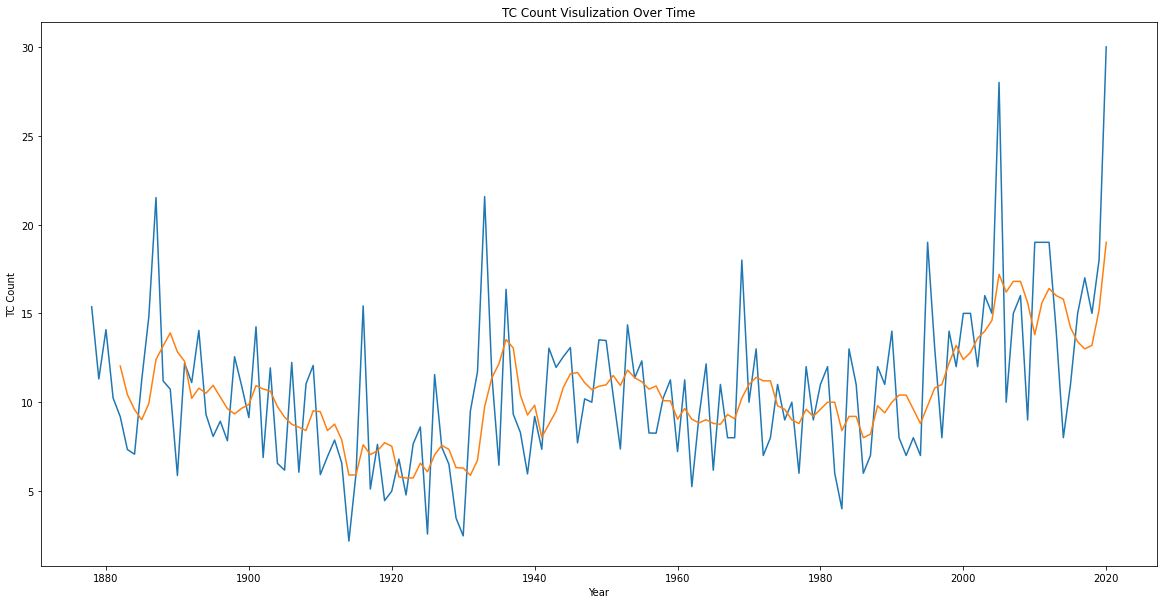

In [82]:
# Plot of TC Count
df_VK08_TCCount[ '7year_rolling_avg' ] = df_VK08_TCCount.VK08_TCCount.rolling(5).mean()
plt.figure(figsize=(20,10))
plt.plot(df_VK08_TCCount['Year'],df_VK08_TCCount['VK08_TCCount'])
plt.plot(df_VK08_TCCount['Year'],df_VK08_TCCount['7year_rolling_avg'])
plt.gca().set(title='TC Count Visulization Over Time', xlabel="Year", ylabel="TC Count")

{'whiskers': [<matplotlib.lines.Line2D at 0x7f960bf24fa0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f960bf356a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f960bf24c40>],
 'medians': [<matplotlib.lines.Line2D at 0x7f960bf35d30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f960bf680a0>],
 'means': []}

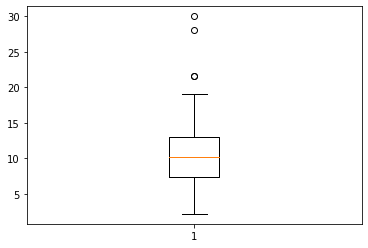

In [83]:
plt.boxplot(df_VK08_TCCount['VK08_TCCount'])

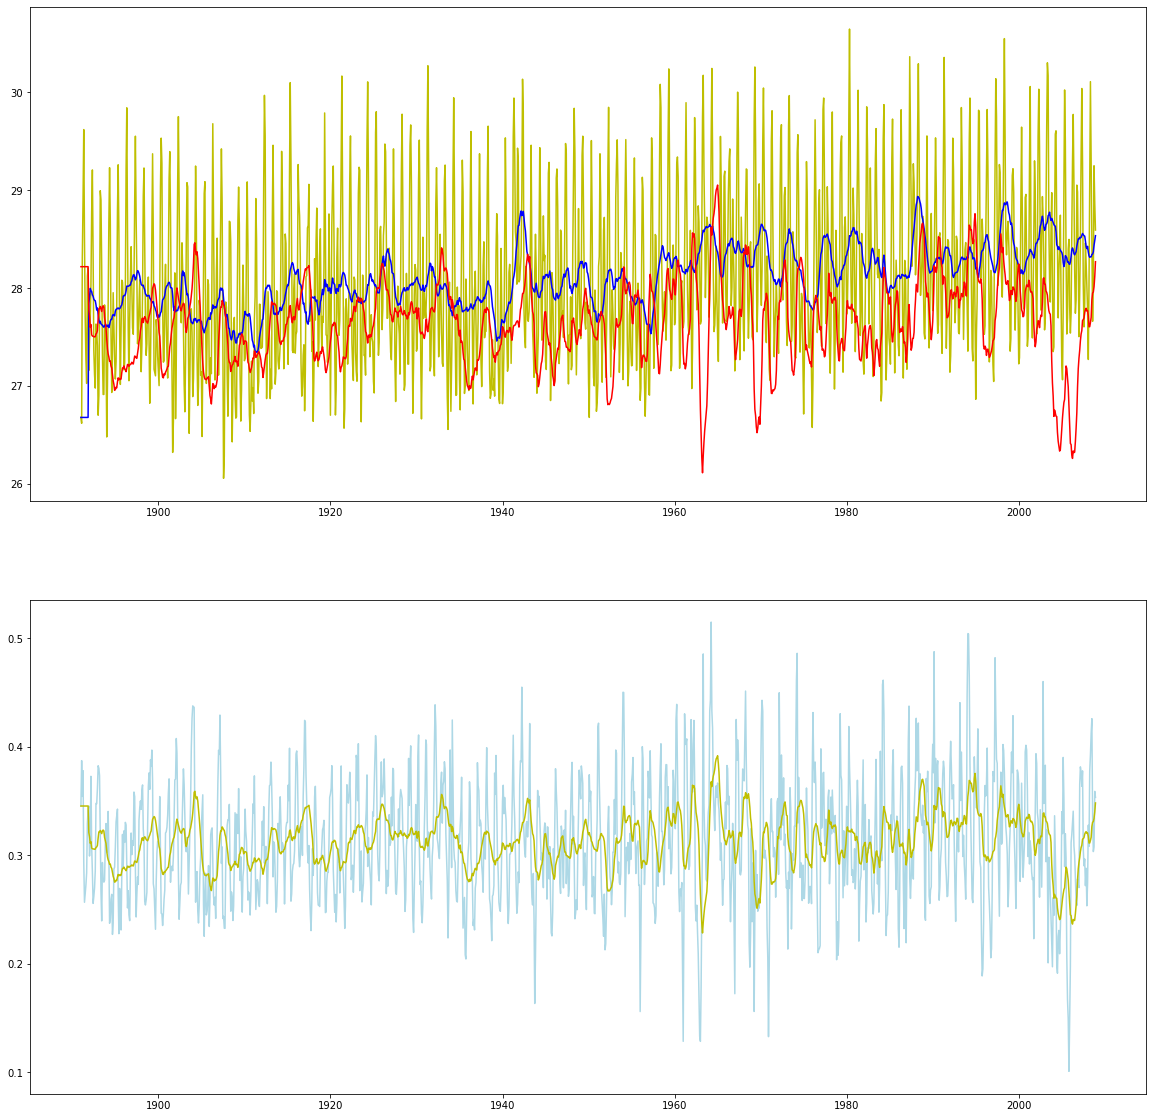

In [106]:
lon = 70 - 40
lat = 15 - 10
ssh_lon = lon*2
ssh_lat = lat*2

# Plot of SSH and SST in one location
# df_VK08_TCCount[ '7year_rolling_avg' ] = df_VK08_TCCount.VK08_TCCount.rolling(5).mean()
temp_sst = []
temp_ssh = []
for i in range(len(df_combined)):
    temp_sst.append(df_combined['sst'][i][lat][lon])
    temp_ssh.append(df_combined['ssh'][i][ssh_lat][ssh_lon])
w = 12
temp_sstAvg = [df_combined['sst'][0][lat][lon]] * (w-1)
temp_sshAvg = [df_combined['ssh'][0][ssh_lat][ssh_lon]] * (w-1)
temp_sstAvg.extend(np.convolve(temp_sst, np.ones(w), 'valid') / w)
temp_sshAvg.extend(np.convolve(temp_ssh, np.ones(w), 'valid') / w)
plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.plot(df_combined['time'],temp_sst,color='y')
plt.plot(df_combined['time'],temp_sstAvg,'b')
plt.plot(df_combined['time'],np.array(temp_sshAvg)*18+22,'r')
plt.subplot(2,1,2)
plt.plot(df_combined['time'],temp_ssh,color = 'lightblue')
plt.plot(df_combined['time'],temp_sshAvg,'y')
df_VK08_TCCount[ '7year_rolling_avg' ] = df_VK08_TCCount.VK08_TCCount.rolling(5).mean()

In [92]:
from scipy.stats.stats import pearsonr   
print(pearsonr(temp_sstAvg,temp_sshAvg))

(0.1318471773870879, 6.399709942917162e-07)


### IBTrACS Visualziation

In [2]:
import xarray as xr
import netCDF4 as nc
#ibtracsNC = xr.open_dataset("IBTrACS/IBTrACS.ALL.v04r00.nc" , decode_times=True)
ibtracs = pd.read_csv("IBTrACS/ibtracs.NA.list.v04r00.csv")

/Users/jackzhang/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,2,3,8,9,14,19,20,23,24,161,162) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#ibtracsNC

In [4]:
#ibtracsNC.where(((ibtracsNC.lon<-40 )&(ibtracsNC.lon>-80) & (ibtracsNC.lat>10 )&(ibtracsNC.lat<20)), drop=True)

In [5]:
ibtracs_unitDrop = ibtracs.iloc[1:]
ibtracs_unitDrop['LON'] = pd.to_numeric(ibtracs_unitDrop['LON'])
ibtracs_unitDrop['LAT'] = pd.to_numeric(ibtracs_unitDrop['LAT'])
ibtracs_NA = ibtracs_unitDrop.loc[(ibtracs_unitDrop['LON'] <= -40) & (ibtracs_unitDrop['LON'] >= -80) & (ibtracs_unitDrop['LAT'] >= 10) & (ibtracs_unitDrop['LAT'] <=20 )]


<ipython-input-5-241a7f144fda>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ibtracs_unitDrop['LON'] = pd.to_numeric(ibtracs_unitDrop['LON'])
<ipython-input-5-241a7f144fda>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ibtracs_unitDrop['LAT'] = pd.to_numeric(ibtracs_unitDrop['LAT'])


In [6]:
ibtracs_NA

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
80,1851192N12300,1851,8,NaN,CS,NOT_NAMED,1851-07-10 12:00:00,TS,12.0000,-60.0000,...,,,,,,,,,,
83,1851214N14321,1851,9,NaN,NaN,NOT_NAMED,1851-08-01 18:00:00,TS,13.6000,-40.0000,...,,,,,,,,,10,275
84,1851214N14321,1851,9,NaN,NaN,NOT_NAMED,1851-08-01 21:00:00,TS,13.6424,-40.5001,...,,,,,,,,,10,276
85,1851214N14321,1851,9,NaN,NaN,NOT_NAMED,1851-08-02 00:00:00,TS,13.7000,-41.0000,...,,,,,,,,,10,279
86,1851214N14321,1851,9,NaN,NaN,NOT_NAMED,1851-08-02 03:00:00,TS,13.7999,-41.4999,...,,,,,,,,,10,282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125161,2022263N10313,2022,66,NaN,CS,IAN,2022-09-25 06:00:00,TS,14.6000,-78.3000,...,,,,12,,,,30,11,278
125162,2022263N10313,2022,66,NaN,CS,IAN,2022-09-25 09:00:00,TS,14.7476,-78.8874,...,,,,12,,,,30,11,291
125163,2022263N10313,2022,66,NaN,CS,IAN,2022-09-25 12:00:00,TS,15.0000,-79.4000,...,,,,12,30,,,30,10,304
125164,2022263N10313,2022,66,NaN,CS,IAN,2022-09-25 15:00:00,TS,15.2897,-79.7155,...,,,,12,30,,,37,9,320


In [25]:
ibtracs_NA['SEASON'] = pd.to_numeric(ibtracs_NA['SEASON'])
ibtracs_NA['ISO_TIME'] = pd.to_datetime(ibtracs_NA['ISO_TIME'])
ibtracs_NA['NUMBER'] = pd.to_numeric(ibtracs_NA['NUMBER'])
ibtracs_NA_recent = ibtracs_NA[['SEASON','LAT','LON','NUMBER','ISO_TIME']]
ibtracs_NA_recent = ibtracs_NA_recent.loc[ibtracs_NA_recent['SEASON'] >= 1950]

<ipython-input-25-5436b24a4476>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ibtracs_NA['SEASON'] = pd.to_numeric(ibtracs_NA['SEASON'])
<ipython-input-25-5436b24a4476>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ibtracs_NA['ISO_TIME'] = pd.to_datetime(ibtracs_NA['ISO_TIME'])
<ipython-input-25-5436b24a4476>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [32]:
ibtracs_NA_recent['Month'] = ibtracs_NA_recent['ISO_TIME'].dt.month

In [51]:
np.unique(ibtracs_NA_recent.loc[(ibtracs_NA_recent['SEASON'] == 1990)]['Month'])

array([ 7,  8,  9, 10])

In [52]:
ibtracs_NA_recent

,SEASON,LAT,LON,NUMBER,ISO_TIME,Month
62381,1950,17.1000,-55.5000,58,1950-08-12 00:00:00,8
62382,1950,17.4176,-55.8722,58,1950-08-12 03:00:00,8
62383,1950,17.7000,-56.3000,58,1950-08-12 06:00:00,8
62384,1950,17.9350,-56.8204,58,1950-08-12 09:00:00,8
62385,1950,18.2000,-57.4000,58,1950-08-12 12:00:00,8
...,...,...,...,...,...,...
125161,2022,14.6000,-78.3000,66,2022-09-25 06:00:00,9
125162,2022,14.7476,-78.8874,66,2022-09-25 09:00:00,9
125163,2022,15.0000,-79.4000,66,2022-09-25 12:00:00,9
125164,2022,15.2897,-79.7155,66,2022-09-25 15:00:00,9


ValueError: Argument Z must be 2-dimensional.

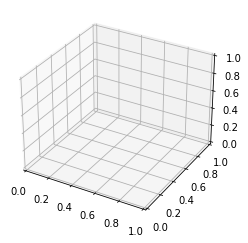

In [58]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = ibtracs_NA_recent.loc[(ibtracs_NA_recent['SEASON'] == 2021) & (ibtracs_NA_recent['Month'] == 9)]['LAT']
Y = ibtracs_NA_recent.loc[(ibtracs_NA_recent['SEASON'] == 2021) & (ibtracs_NA_recent['Month'] == 9)]['LON']
X, Y = np.meshgrid(X, Y)
Z = ibtracs_NA_recent.loc[(ibtracs_NA_recent['SEASON'] == 2021) & (ibtracs_NA_recent['Month'] == 9)]['NUMBER']

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [55]:
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

In [59]:
X

array([[14.4   , 14.5347, 14.7   , ..., 19.3924, 19.7   , 19.9924],
       [14.4   , 14.5347, 14.7   , ..., 19.3924, 19.7   , 19.9924],
       [14.4   , 14.5347, 14.7   , ..., 19.3924, 19.7   , 19.9924],
       ...,
       [14.4   , 14.5347, 14.7   , ..., 19.3924, 19.7   , 19.9924],
       [14.4   , 14.5347, 14.7   , ..., 19.3924, 19.7   , 19.9924],
       [14.4   , 14.5347, 14.7   , ..., 19.3924, 19.7   , 19.9924]])

In [108]:
wShear = xr.open_dataset("wshear.nc" , decode_times=False)

In [109]:
wShear

<xarray.Dataset>
Dimensions:  (lon: 144, lat: 72, time: 456)
Coordinates:
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * time     (time) float64 0.0 744.0 1.44e+03 ... 3.309e+05 3.317e+05 3.324e+05
Data variables:
    wshear   (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.8.0rc5 (http://mpimet.mpg....
    Conventions:  CF-1.6
    history:      Fri Oct 09 10:03:53 2020: cdo selname,wshear wshear_orig.nc...
    CDO:          Climate Data Operators version 1.8.0rc5 (http://mpimet.mpg....

In [126]:
df_wShear = pd.DataFrame()
df_wShear['time'] = np.array((wShear['time']))
df_wShear['wshear'] = ''
for i in range(len(df_wShear)):
  #df_sst['time'][i] = pd.Timestamp(1891, 1, 1) + timedelta(days= df_sst['time'][i])
  df_wShear['wshear'][i] = np.array((wShear['wshear'][i]))

<ipython-input-126-bdbecb148921>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wShear['wshear'][i] = np.array((wShear['wshear'][i]))


In [128]:
df_wShear

,time,wshear
0,0.0,"[[3.0319555, 3.039503, 3.0334258, 3.0336602, 3..."
1,744.0,"[[9.6326065, 9.5503, 9.461954, 9.377073, 9.290..."
2,1440.0,"[[7.03711, 6.9525485, 6.873125, 6.7895603, 6.7..."
3,2184.0,"[[5.9532413, 5.8494325, 5.758863, 5.65936, 5.5..."
4,2904.0,"[[9.252541, 9.199626, 9.144942, 9.090212, 9.03..."
...,...,...
451,329448.0,"[[11.113124, 11.029326, 10.928824, 10.831234, ..."
452,330192.0,"[[10.97793, 10.919955, 10.843183, 10.76308, 10..."
453,330912.0,"[[7.898461, 7.8304005, 7.7531624, 7.6763487, 7..."
454,331656.0,"[[8.594661, 8.538686, 8.480033, 8.417126, 8.35..."


In [131]:
sample = xr.open_dataset("HTTP_services.cgi?FILENAME=%2Fdata%2FMERRA2_MONTHLY%2FM2TMNPUDT.5.12.4%2F1980%2FMERRA2_100.tavgM_3d_udt_Np.198001.nc4&FORMAT=bmM0Lw&BBOX=10,-80,40,-40&LABEL=MERRA2_100.tavgM_3d_udt_Np.198001.SUB.nc&SHORTNAME=M2TMNPUDT&SERVICE=L34RS_MERR" , decode_times=False)